In [1]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd
from sksurv.datasets import load_veterans_lung_cancer
import matplotlib.pyplot as plt
#from sksurv.nonparametric import kaplan_meier_estimator
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.preprocessing import OneHotEncoder


In [4]:
df_x = load_veterans_lung_cancer()[0]
df_y = pd.DataFrame(load_veterans_lung_cancer()[1])

In [5]:
df_y.groupby(by='Status')['Survival_in_days'].count()

Status
False      9
True     128
Name: Survival_in_days, dtype: int64

In [6]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age_in_years           137 non-null    float64 
 1   Celltype               137 non-null    category
 2   Karnofsky_score        137 non-null    float64 
 3   Months_from_Diagnosis  137 non-null    float64 
 4   Prior_therapy          137 non-null    category
 5   Treatment              137 non-null    category
dtypes: category(3), float64(3)
memory usage: 4.2 KB


In [7]:
df_x.describe()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis
count,137.000000,137.000000,137.000000
mean,58.306569,58.569343,8.773723
std,10.541628,20.039592,10.612141
min,34.000000,10.000000,1.000000
25%,51.000000,40.000000,3.000000
50%,62.000000,60.000000,5.000000
75%,66.000000,75.000000,11.000000
max,81.000000,99.000000,87.000000


In [8]:
df_x.isnull().sum()

Age_in_years             0
Celltype                 0
Karnofsky_score          0
Months_from_Diagnosis    0
Prior_therapy            0
Treatment                0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


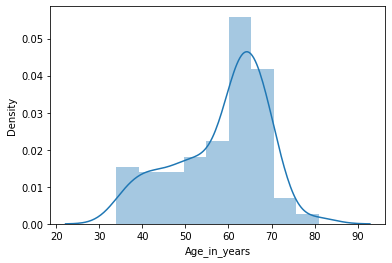

In [9]:
sns.distplot(df_x['Age_in_years'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


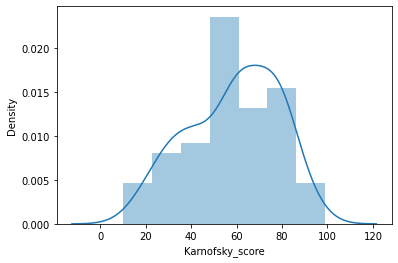

In [10]:
sns.distplot(df_x['Karnofsky_score'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


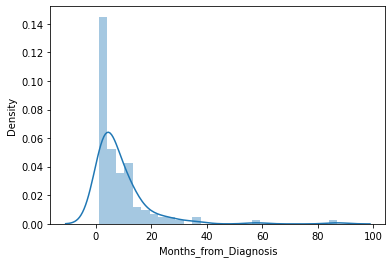

In [11]:
sns.distplot(df_x['Months_from_Diagnosis'])

In [12]:
print(df_x.Celltype.unique())
print(df_x.Prior_therapy.unique())
print(df_x.Treatment.unique())


['squamous', 'smallcell', 'adeno', 'large']
Categories (4, object): ['adeno', 'large', 'smallcell', 'squamous']
['no', 'yes']
Categories (2, object): ['no', 'yes']
['standard', 'test']
Categories (2, object): ['standard', 'test']


Text(0.5, 1.0, 'Median Survival time is 80')

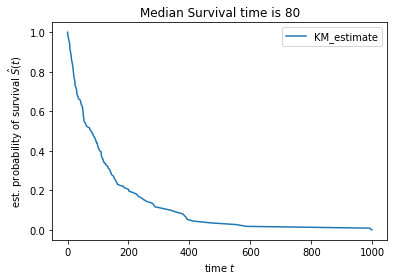

In [13]:
# Survival Function
%matplotlib inline
kmf = KaplanMeierFitter()
kmf.fit(durations = df_y["Survival_in_days"], event_observed = df_y["Status"])
kmf.survival_function_.plot()
#kmf.plot_survival_function()
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Median Survival time is %d" %(kmf.median_survival_time_))

In [14]:
# Creating a function to identify survival function on basis of various categories
def plot_survival_function(column):
  kmf = KaplanMeierFitter()
  column_array = df_x[column].unique()
  for val in column_array:
    index = (df_x[column] == val)
    kmf.fit(durations = df_y["Survival_in_days"][index], event_observed = df_y["Status"][index], 
            label = "%s (n=%d)" %(val,index.sum()))
    kmf.plot_survival_function()
    print("Median of %s is %d" %(val,kmf.median_survival_time_))

  plt.ylabel("est. probability of survival $\hat{S}(t)$")
  plt.xlabel("time $t$")
  plt.title("Survival Curves on basis of %s" %(column))

Median of squamous is 118
Median of smallcell is 51
Median of adeno is 51
Median of large is 156


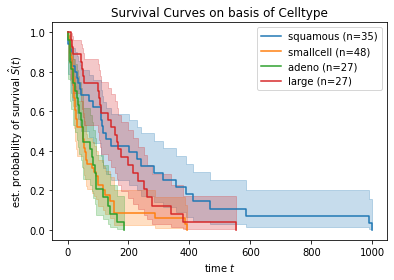

In [15]:
plot_survival_function("Celltype")

Median of no is 80
Median of yes is 82


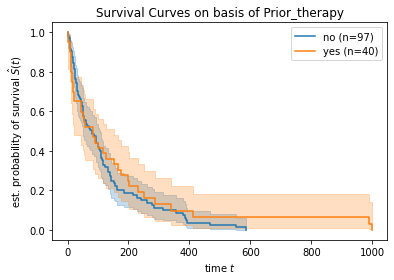

In [16]:
plot_survival_function("Prior_therapy")

Median of standard is 103
Median of test is 52


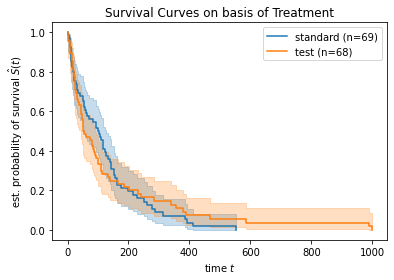

In [17]:
plot_survival_function("Treatment")

In [18]:
index = (df_x["Prior_therapy"] == 'yes')
results = logrank_test(df_y["Survival_in_days"][index],df_y["Survival_in_days"][~index],df_y["Status"][index],df_y["Status"][~index],alpha=0.95)
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.50 0.48      1.06

In [34]:
df_x_numeric = OneHotEncoder().fit_transform(df_x)
df_model = pd.concat([df_x_numeric,df_y],axis=1)
df_model.head()
df_model["Status"] = df_model["Status"].apply(lambda x: 1 if x== True else 0)
df_model.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [40]:
#### Cox Proportional Hazards Model

# Survival Regression

# Cox Model

cph = CoxPHFitter()
cph.fit(df_model[['Prior_therapy=yes','Status','Survival_in_days']],'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -505.19
         time fit was run = 2023-01-05 17:59:53 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Prior_therapy=yes  -0.14       0.87       0.20            -0.54             0.25                 0.59                 1.28

                    cmp to     z    p   -log2(p)
covariate                                       
Prior_therapy=yes     0.00 -0.71 0.48       1.07
---
Concordance = 0.49
Partial AIC = 1012.38
log-likelihood ratio test = 0.52 on 1 df
-log2(p) of ll-ratio test = 1.08

In [44]:
index = (df_x["Treatment"] == 'test')
results = logrank_test(df_y["Survival_in_days"][index],df_y["Survival_in_days"][~index],
                       df_y["Status"][index],df_y["Status"][~index],
                       alpha=0.95)
results.print_summary()
print(results.p_value)       
print(results.test_statistic)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.93      0.11

0.9277272333400758
0.008227343202350305


In [45]:
#### Cox Proportional Hazards Model

# Survival Regression

# Cox Model

cph = CoxPHFitter()
cph.fit(df_model[['Treatment=test','Status','Survival_in_days']],'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -505.44
         time fit was run = 2023-01-05 18:05:11 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Treatment=test   0.02       1.02       0.18            -0.34             0.37                 0.71                 1.45

                 cmp to    z    p   -log2(p)
covariate                                   
Treatment=test     0.00 0.10 0.92       0.12
---
Concordance = 0.53
Partial AIC = 1012.89
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.12

In [42]:
#### Cox Proportional Hazards Model

# Survival Regression

# Cox Model

cph = CoxPHFitter()
cph.fit(df_model[['Celltype=large','Celltype=smallcell','Celltype=squamous','Status','Survival_in_days']],'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -493.02
         time fit was run = 2023-01-05 18:04:02 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Celltype=large      -0.92       0.40       0.29            -1.48            -0.35                 0.23                 0.70
Celltype=smallcell  -0.15       0.86       0.25            -0.64             0.34                 0.53                 1.41
Celltype=squamous   -1.15       0.32       0.29            -1.72            -0.57                 0.18                 0.56

                     cmp to     z      p   -log2(p)
covariate                                          
Celltype=large         0.00 -3.19 <0.005       9.44
Celltype=smallcell     0.00 -0.59   0.56       0.84
Celltype=squamous      0.00 -3.92 <0.005      13.46
---
Concordance = 0.61
Partial AIC = 992.05
log-likelihood ratio test = 24.85 on 3 df
-log2(p) of ll-ratio test = 15.88

In [46]:
#### Cox Proportional Hazards Model
# Survival Regression
# Cox Model

cph = CoxPHFitter()
cph.fit(df_model[['Age_in_years','Status','Survival_in_days']],'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -505.14
         time fit was run = 2023-01-05 18:13:04 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Age_in_years   0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03

               cmp to    z    p   -log2(p)
covariate                                 
Age_in_years     0.00 0.78 0.43       1.21
---
Concordance = 0.52
Partial AIC = 1012.27
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.22

In [47]:
df_model.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test,Status,Survival_in_days
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0,1,72.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0,1,411.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0,1,228.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0,1,126.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0,1,118.0


In [48]:
#### Cox Proportional Hazards Model
# Survival Regression
# Cox Model

cph = CoxPHFitter()
cph.fit(df_model[['Karnofsky_score','Status','Survival_in_days']],'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -484.43
         time fit was run = 2023-01-05 18:14:19 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
Karnofsky_score  -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98

                  cmp to     z      p   -log2(p)
covariate                                       
Karnofsky_score     0.00 -6.59 <0.005      34.37
---
Concordance = 0.71
Partial AIC = 970.87
log-likelihood ratio test = 42.03 on 1 df
-log2(p) of ll-ratio test = 33.37

In [49]:
#### Cox Proportional Hazards Model
# Survival Regression
# Cox Model

cph = CoxPHFitter()
cph.fit(df_model[['Months_from_Diagnosis','Status','Survival_in_days']],'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -504.99
         time fit was run = 2023-01-05 18:15:08 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Months_from_Diagnosis   0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03

                        cmp to    z    p   -log2(p)
covariate                                          
Months_from_Diagnosis     0.00 1.01 0.31       1.69
---
Concordance = 0.51
Partial AIC = 1011.99
log-likelihood ratio test = 0.91 on 1 df
-log2(p) of ll-ratio test = 1.56

In [50]:
cph = CoxPHFitter()
cph.fit(df_model,'Survival_in_days',event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -474.40
         time fit was run = 2023-01-05 18:15:54 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_in_years           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Celltype=large         -0.79       0.45       0.30            -1.39            -0.20                 0.25                 0.82
Celltype=smallcell     -0.33       0.72       0.28            -0.88             0.21                 0.42                 1.23
Celltype=squamous      -1.20       0.30       0.30            -1.79            -0.61                 0.17                 0.55
Karnofsky_score        -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
Months_from_Diagnosis   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
Prior_therapy=yes       0.07       1.07       0.23            -0.38             0.53                 0.68                 1.69
Treatment=test          0.29       1.34       0.21            -0.11             0.70                 0.89                 2.02

                        cmp to     z      p   -log2(p)
covariate                                             
Age_in_years              0.00 -0.94   0.35       1.52
Celltype=large            0.00 -2.62   0.01       6.85
Celltype=smallcell        0.00 -1.21   0.23       2.15
Celltype=squamous         0.00 -3.97 <0.005      13.79
Karnofsky_score           0.00 -5.96 <0.005      28.55
Months_from_Diagnosis     0.00  0.01   0.99       0.01
Prior_therapy=yes         0.00  0.31   0.76       0.40
Treatment=test            0.00  1.42   0.16       2.68
---
Concordance = 0.74
Partial AIC = 964.79
log-likelihood ratio test = 62.10 on 8 df
-log2(p) of ll-ratio test = 32.37